In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import re
import jieba
import jieba.analyse
%matplotlib inline

In [2]:
# 读取数据集
def load_data():
    # 读取训练集
    train_file = open("./inews_train.txt", encoding='utf-8')
    train_collection = train_file.readlines()
    train_data = []
    for i in train_collection:
        i = i.split("_!_")
        # 提取30个关键词 + " " + 标题分词
        i[2] = " ".join(jieba.analyse.textrank(i[3], topK=30)) + " " + " ".join(jieba.cut(re.sub(r'[^\w\s]','',i[2].strip()), cut_all=False))
        i.append(len(i[2].split()))
        i.pop(1) # 去除ID
        i.pop(2)
        train_data.append(i)
    train_df = pd.DataFrame(train_data)
    train_df.columns = ["label", "cutword", "cutwordnum"]
    
    # 读取验证集
    val_file = open("./inews_dev.txt", encoding='utf-8')
    val_collection = val_file.readlines()
    val_data = []
    for i in val_collection:
        i = i.split("_!_")
        i[2] = " ".join(jieba.analyse.textrank(i[3], topK=30)) + " " + " ".join(jieba.cut(re.sub(r'[^\w\s]','',i[2].strip()), cut_all=False))
        i.append(len(i[2].split()))
        i.pop(1) # 去除ID
        i.pop(2)
        val_data.append(i)
    val_df = pd.DataFrame(val_data)
    val_df.columns = ["label", "cutword", "cutwordnum"]
    
    # 读取测试集
    test_file = open("./inews_test.txt", encoding='utf-8')
    test_collection = test_file.readlines()
    test_data = []
    for i in test_collection:
        i = i.split("_!_")
        i[2] = " ".join(jieba.analyse.textrank(i[3], topK=30)) + " " + " ".join(jieba.cut(re.sub(r'[^\w\s]','',i[2].strip()), cut_all=False))
        i.append(len(i[2].split()))
        i.pop(1) # 去除ID
        i.pop(2)
        test_data.append(i)
    test_df = pd.DataFrame(test_data)
    test_df.columns = ["label", "cutword", "cutwordnum"]
    
    return train_df, val_df, test_df

In [3]:
train_df, val_df, test_df = load_data()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yinzh\AppData\Local\Temp\jieba.cache
Loading model cost 0.900 seconds.
Prefix dict has been built successfully.


In [4]:
train_df.head()

,label,cutword,cutwordnum
0,label,title,1
1,1,活动 家具 中央 夜购 苹果 数量 音乐 签到 品牌 儿童 小朋友 转基因 知名 现场 潮流...,36
2,1,朋友 大家 个股 时期 直播 买进 股票 交流 涨幅 关注 药辅 山河 超过 无偿 完全免费...,42
3,0,基干民兵 民兵 意识 训练 全镇 军事训练 队伍 开展 政治 提升 队列训练 国防 常识 加...,36
4,2,进行 驾驶 没有 小伙子 小伙 无证 民警 地点 上路 指定 考出 达到 标准 训练 专业 ...,39


In [25]:
train_df = train_df.drop(index=[0])

数据探索

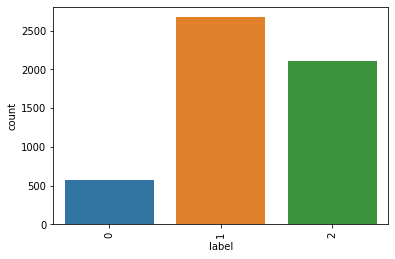

In [26]:
## 查看训练集都有哪些标签
plt.figure()
sns.countplot(train_df.label)
plt.xlabel('label')
plt.xticks(rotation=90)
plt.show()

共15种标签，标签分布比较均匀。

count    5355.000000
mean       37.459010
std         9.757575
min         1.000000
25%        37.000000
50%        40.000000
75%        43.000000
max        63.000000
Name: cutwordnum, dtype: float64


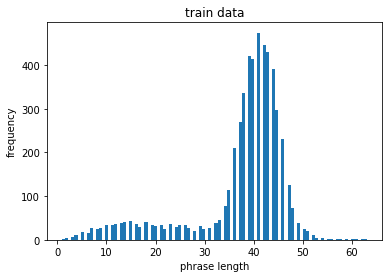

In [27]:
## 分析训练集中词组数量的分布
print(train_df.cutwordnum.describe())
plt.figure()
plt.hist(train_df.cutwordnum,bins=100)
plt.xlabel("phrase length")
plt.ylabel("frequency")
plt.title("train data")
plt.show()

In [28]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

In [29]:
## 对数据集的标签数据进行重新编码
train_y = train_df.label
val_y = val_df.label
test_y = test_df.label
le = LabelEncoder()
train_y = le.fit_transform(train_y).reshape(-1,1)
val_y = le.transform(val_y).reshape(-1,1)
test_y = le.transform(test_y).reshape(-1,1)

## 对数据集的标签数据进行one-hot编码
ohe = OneHotEncoder()
train_y = ohe.fit_transform(train_y).toarray()
val_y = ohe.transform(val_y).toarray()
test_y = ohe.transform(test_y).toarray()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


使用Tokenizer对词组进行编码。

In [30]:
max_words = 5000
max_len = 600
tok = Tokenizer(num_words=max_words)  ## 使用的最大词语数为5000
tok.fit_on_texts(train_df.cutword)

## 使用word_index属性可以看到每次词对应的编码
## 使用word_counts属性可以看到每个词对应的频数
for ii,iterm in enumerate(tok.word_index.items()):
    if ii < 10:
        print(iterm)
    else:
        break
print("===================")  
for ii,iterm in enumerate(tok.word_counts.items()):
    if ii < 10:
        print(iterm)
    else:
        break

('的', 1)
('没有', 2)
('进行', 3)
('工作', 4)
('发生', 5)
('问题', 6)
('中国', 7)
('被', 8)
('了', 9)
('公司', 10)
('活动', 455)
('家具', 27)
('中央', 49)
('夜购', 1)
('苹果', 45)
('数量', 21)
('音乐', 30)
('签到', 9)
('品牌', 80)
('儿童', 59)


使用tok.texts_to_sequences()将数据转化为序列，并使用sequence.pad_sequences()将每个序列调整为相同的长度。

In [31]:
## 对每个词编码之后，每句新闻中的每个词就可以用对应的编码表示，即每条新闻可以转变成一个向量了：
train_seq = tok.texts_to_sequences(train_df.cutword)
val_seq = tok.texts_to_sequences(val_df.cutword)
test_seq = tok.texts_to_sequences(test_df.cutword)
## 将每个序列调整为相同的长度
train_seq_mat = sequence.pad_sequences(train_seq,maxlen=max_len)
val_seq_mat = sequence.pad_sequences(val_seq,maxlen=max_len)
test_seq_mat = sequence.pad_sequences(test_seq,maxlen=max_len)

print(train_seq_mat.shape)
print(val_seq_mat.shape)
print(test_seq_mat.shape)

(5355, 600)
(1000, 600)
(1000, 600)


In [32]:
train_df.label.drop_duplicates()

1    1
3    0
4    2
Name: label, dtype: object

In [33]:
len(train_df.label.drop_duplicates())

3

建立LSTM模型并训练。

In [49]:
## 定义LSTM模型
inputs = Input(name='inputs',shape=[max_len])
## Embedding(词汇表大小,batch大小,每个新闻的词长)
layer = Embedding(max_words+1,128,input_length=max_len)(inputs)
layer = LSTM(128)(layer)
layer = Dense(32,activation="relu",name="FC1")(layer)
# layer = Dropout(0.5)(layer)
layer = Dense(3,activation="softmax",name="FC2")(layer)
model = Model(inputs=inputs,outputs=layer)
model.summary()
model.compile(loss="categorical_crossentropy",optimizer=RMSprop(),metrics=["accuracy"])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 600)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 600, 128)          640128    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
FC1 (Dense)                  (None, 32)                4128      
_________________________________________________________________
FC2 (Dense)                  (None, 3)                 99        
Total params: 775,939
Trainable params: 775,939
Non-trainable params: 0
_________________________________________________________________


In [40]:
## 模型训练
model_fit = model.fit(train_seq_mat,train_y,batch_size=32,epochs=10,
                      validation_data=(val_seq_mat,val_y),
                      callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)] ## 当val-loss不再提升时停止训练
                     )

Train on 5355 samples, validate on 1000 samples
Epoch 1/10
5355/5355 [==============================] - 77s 14ms/step - loss: 0.7468 - accuracy: 0.6764 - val_loss: 0.6023 - val_accuracy: 0.7530
Epoch 2/10
5355/5355 [==============================] - 76s 14ms/step - loss: 0.4405 - accuracy: 0.8213 - val_loss: 0.5575 - val_accuracy: 0.7600
Epoch 3/10
5355/5355 [==============================] - 76s 14ms/step - loss: 0.3227 - accuracy: 0.8777 - val_loss: 0.5769 - val_accuracy: 0.7380


In [41]:
## 对测试集进行预测
test_pre = model.predict(test_seq_mat)

## 评价预测效果，计算混淆矩阵
confm = metrics.confusion_matrix(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1))

In [42]:
Labname =  list(train_df.label.drop_duplicates())

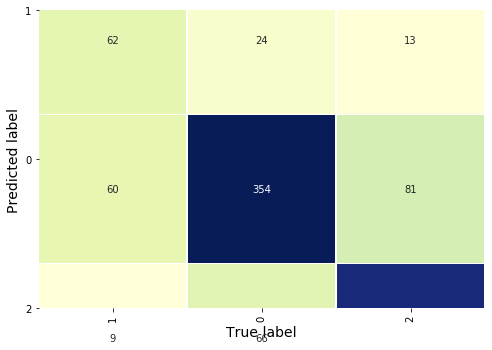

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       131
           1       0.72      0.80      0.75       444
           2       0.82      0.78      0.80       425

    accuracy                           0.75      1000
   macro avg       0.72      0.68      0.70      1000
weighted avg       0.75      0.75      0.74      1000



In [43]:
## 混淆矩阵可视化
plt.figure(figsize=(8,8))
sns.heatmap(confm.T, square=True, annot=True,
            fmt='d', cbar=False,linewidths=.8,
            cmap="YlGnBu")
plt.xlabel('True label',size = 14)
plt.ylabel('Predicted label',size = 14)
plt.xticks(np.arange(len(Labname))+0.5,Labname,rotation=90)
plt.yticks(np.arange(len(Labname))+0.3,Labname,rotation=0)
plt.show()


print(metrics.classification_report(np.argmax(test_pre,axis=1),np.argmax(test_y,axis=1)))

用时1小时，测试集准确率75%，考虑到0的f1-score较低，可能由于0的标签数量比较少导致。

In [44]:
# 保存训练好的Tokenizer，和导入
import pickle
# saving
with open('tok_inews.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
# import pickle
# # loading
# with open('tok_thucnews.pickle', 'rb') as handle:
#     tok = pickle.load(handle)
# ## 使用word_index属性可以看到每次词对应的编码
# ## 使用word_counts属性可以看到每个词对应的频数
# for ii,iterm in enumerate(tok.word_index.items()):
#     if ii < 10:
#         print(iterm)
#     else:
#         break
# print("===================")  
# for ii,iterm in enumerate(tok.word_counts.items()):
#     if ii < 10:
#         print(iterm)
#     else:
#         break

In [46]:
## 模型的保存和导入
from keras.models import load_model
# 保存模型
model.save('inews_model.h5')  

In [47]:
# # 导入已经训练好的模型
# model = load_model('my_model.h5')
# ## 使用tok对验证数据集重新预处理
# val_seq = tok.texts_to_sequences(val_df.cutword)
# ## 将每个序列调整为相同的长度
# val_seq_mat = sequence.pad_sequences(val_seq,maxlen=max_len)
# ## 对验证集进行预测
# val_pre = model.predict(val_seq_mat)
# print(metrics.classification_report(np.argmax(val_pre,axis=1),np.argmax(val_y,axis=1)))